<a href="https://colab.research.google.com/github/carlos-alves-one/-SSDM-Coursework-1/blob/main/glaucoma_detection_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Goldsmiths University of London
### MSc. Data Science and Artificial Intelligence
### Module: Artificial Intelligence
### Author: Carlos Manuel De Oliveira Alves
### Student: cdeol003
### Coursework No.2

#Project
VisionGuard AI: Deep Learning for Early Glaucoma Detection

# Introduction

The purpose of this research is to outline the progression of a deep-learning model designed to identify glaucoma through the analysis of ocular pictures. Glaucoma is a debilitating ocular disorder that, if left undetected and untreated in its early stages, can result in complete vision loss. Effective screening procedures are necessary due to the asymptomatic nature of the early stages of glaucoma. Deep learning, specifically convolutional neural networks (CNNs), has demonstrated considerable potential in image identification tasks and can aid in the early detection of glaucoma. The dataset utilised in this research comprises a collection of ocular pictures accompanied by a binary classification showing the presence or absence of glaucoma. The ExpCDR, or 'Cup to Disc Ratio', is a crucial clinical parameter utilised in evaluating glaucoma for each image.

# Methodology

## Data Preprocessing

The photos will undergo a process of loading, resizing to a consistent dimension, and normalisation to ensure that their pixel values fall within the range of 0 to 1. Furthermore, it is possible to employ data augmentation methods, such as rotations, shifts, and flips, in order to augment the size and diversity of the dataset. This can be beneficial in mitigating the issue of overfitting.

### Load the data

In [1]:
# Imports the 'drive' module from 'google.colab' and mounts the Google Drive to
# the '/content/drive' directory in the Colab environment.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import the pandas library and give it the alias 'pd' for data manipulation and analysis
import pandas as pd

# Load the dataset glaucoma from Google Drive
data_path = '/content/drive/MyDrive/glaucoma.csv'
glaucoma_data = pd.read_csv(data_path)

# Display the first few rows of the dataframe
glaucoma_data.head()


,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0


Dataset source: https://www.kaggle.com/datasets/sshikamaru/glaucoma-detection

License: CC0 - Public Domain
https://creativecommons.org/publicdomain/zero/1.0/

The dataset contains the following columns:

    - Filename: The name of the image file.
    - ExpCDR: The 'Cup to Disc Ratio', a crucial parameter for evaluating glaucoma.
    - Eye: Indicates which eye the image corresponds to (OD for right eye, OS for left eye).
    - Set: This could denote the dataset split (e.g., training, validation, or test set), but we would need further clarification.
    - Glaucoma: The binary label indicating the presence (1) or absence (0) of glaucoma.

###Preprocess the Data

Declare function to preprocess a single image:

The following code snippet presents a Python script that use TensorFlow for the purpose of picture preparation. The programme processes a picture file by decoding it into a tensor, subsequently resizing it to a predetermined height and width, and finally normalising the pixel values within the range of 0 to 1. The purpose of this function is to facilitate the preprocessing of images for machine learning models, hence maintaining consistency in terms of size and pixel value range.

In [3]:
# Importing the os module for interacting with the operating system and tensorflow for machine learning tasks
import os
import tensorflow as tf

# Function to preprocess a single image
def preprocess_image(filename, img_height=224, img_width=224, images_directory='/content/drive/MyDrive/Images'):

    # Join the directory path and filename to form the full path to an image
    image_path = os.path.join(images_directory, filename)

    # Read the image file from the specified path into a tensor
    image = tf.io.read_file(image_path)

    # Decode the JPEG image and ensure it has 3 color channels (RGB)
    image = tf.image.decode_jpeg(image, channels=3)

    # Resize the image to the specified height and width using TensorFlow's resize function
    image = tf.image.resize(image, [img_height, img_width])

    # Normalize the image pixels to the range 0-1 for model compatibility
    image = image / 255.0

    # Return image preprocessed
    return image


###Data Augmentation

 Set up data augmentation using the ImageDataGenerator class from tf.keras.preprocessing.image:

 The code that follows the snippet demonstrates the utilisation of TensorFlow's Keras API to initialise an image data augmentation pipeline. More specifically, it employs the ImageDataGenerator class. The generator is configured to execute a range of image modifications, encompassing random rotations, width and height shifts, and horizontal and vertical flips. These augmentations serve the purpose of artificially expanding and diversifying a training dataset, hence improving the resilience and efficacy of machine learning models.

In [4]:
# Import the ImageDataGenerator class from TensorFlow's Keras API for real-time data augmentation of images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data augmentation
data_augmentation = ImageDataGenerator(

    # Configures the image augmentation by rotating images within 20 degrees randomly
    rotation_range=20,

    # Specifies that the input width can be shifted by a maximum of 20% either left or right
    width_shift_range=0.2,

    # Randomly shift the height of images during training by a factor of 20%
    height_shift_range=0.2,

    # Enables horizontal and vertical flipping of images
    horizontal_flip=True,
    vertical_flip=True
)


###Apply Preprocessing and Augmentation to Dataset

This code extracts image filenames and corresponding labels for glaucoma detection from the dataset, preprocesses the images, and then applies data augmentation techniques like rotation and flipping. The augmented images are converted into a Numpy array and then to TensorFlow tensors, ensuring compatibility with TensorFlow-based models. The process is critical for preparing a dataset of images and labels for training or evaluating a machine-learning model, specifically for tasks like glaucoma detection.

In [6]:
# Import the NumPy library for numerical operations.
import numpy as np

# Extract filenames and corresponding glaucoma presence labels from the dataset
filenames = glaucoma_data['Filename'].values
labels = glaucoma_data['Glaucoma'].values

# A placeholder for the images directory
images_directory = '/content/drive/MyDrive/Images'

# Preprocess all images
preprocessed_images = [preprocess_image(f, images_directory=images_directory) for f in filenames]

# Convert the list of images to a Numpy array
images_np = np.array(preprocessed_images)

# Create a generator for augmentation
augmented_images_generator = data_augmentation.flow(images_np, batch_size=1, shuffle=False)

# Collect augmented images
augmented_images = []
for i in range(len(preprocessed_images)):
    # Get the next augmented image from the generator
    augmented_image = next(augmented_images_generator)[0]

    # Remove batch dimension and append to list
    augmented_images.append(augmented_image)

# Convert the list of augmented images to a Tensor
images = tf.stack(augmented_images)

# Convert labels to Tensor
labels = tf.convert_to_tensor(labels)


###Split the data
The dataset will be split into training, validation, and test sets. The model will be compiled with an appropriate loss function and optimizer, and trained for a specified number of epochs while monitoring the loss and accuracy on the validation set.

In [7]:
# Import train_test_split function from scikit-learn to split data into training and test sets
from sklearn.model_selection import train_test_split

# Import TensorFlow for deep learning and train_test_split function for splitting the dataset into training and testing sets
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Convert image and label tensors to numpy arrays for further manipulation or analysis
images_numpy = images.numpy()
labels_numpy = labels.numpy()

# Split the dataset into training set and a combined validation/test set with a 20% size of the original dataset,
# using a fixed random state for reproducibility.
train_images, val_test_images, train_labels, val_test_labels = train_test_split(
    images_numpy, labels_numpy, test_size=0.2, random_state=42
)

# Split the val_test set equally into validation and test sets (50% validation, 50% test)
val_images, test_images, val_labels, test_labels = train_test_split(
    val_test_images, val_test_labels, test_size=0.5, random_state=42)


## Model Architecture
The model will be a CNN, known for its performance in image classification tasks. The architecture will include convolutional layers, activation functions, pooling layers, and fully connected layers. Dropout layers may be included to reduce overfitting.

The code snippet sets up the label data for a neural network-based classification model, ensuring that the labels are in a format that can be effectively used for training and evaluation within a TensorFlow framework. This preprocessing step is critical to the machine learning pipeline for classification problems.

In [8]:
 # Determine the number of unique classes in the training labels
num_classes = len(np.unique(train_labels))

# Convert train labels to one-hot encoded format
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)

# Convert validation labels to one-hot encoded format
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)

# Convert test labels to one-hot encoded format
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)


This code demonstrates the construction, training, and evaluation of a Convolutional Neural Network (CNN) for image classification using TensorFlow. It includes defining the model architecture with convolutional, pooling, and dense layers, followed by compilation with appropriate loss and optimization functions. The model is then trained on labeled image data, evaluated for accuracy on a test set, and the test accuracy is reported, showcasing the end-to-end process of a typical deep learning image classification task.


In [9]:
# Define the input layer with shape 224x224 and 3 color channels (RGB)
inputs = tf.keras.Input(shape=(224, 224, 3))

# Apply a 2D convolution layer with 32 filters, 3x3 kernel, and ReLU activation
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)

# Add a max pooling layer with a 2x2 pool size to reduce spatial dimensions
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

# Add another convolution layer with 64 filters, 3x3 kernel, and ReLU activation
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

# Add a second max pooling layer to further reduce dimensions.
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

# Add a third convolution layer with 128 filters, 3x3 kernel, and ReLU activation
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

# Flatten the output to prepare for the dense layer
x = tf.keras.layers.Flatten()(x)

# Determine the number of classes from the shape of the training labels
num_classes = train_labels.shape[1]

# Create the output layer with 'num_classes' neurons and softmax activation
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

# Build the model by specifying inputs and outputs
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=10, validation_split=0.1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

# Print the accuracy results for this model
print(f"Test accuracy: {test_accuracy:.4f}")


Epoch 1/10
15/15 [==============================] - 12s 106ms/step - loss: 0.9009 - accuracy: 0.6581 - val_loss: 0.5735 - val_accuracy: 0.8269
Epoch 2/10
15/15 [==============================] - 1s 54ms/step - loss: 0.5924 - accuracy: 0.7329 - val_loss: 0.5939 - val_accuracy: 0.8269
Epoch 3/10
15/15 [==============================] - 1s 59ms/step - loss: 0.5907 - accuracy: 0.7329 - val_loss: 0.5834 - val_accuracy: 0.8269
Epoch 4/10
15/15 [==============================] - 1s 57ms/step - loss: 0.5637 - accuracy: 0.7457 - val_loss: 0.5574 - val_accuracy: 0.8269
Epoch 5/10
15/15 [==============================] - 1s 59ms/step - loss: 0.4786 - accuracy: 0.7564 - val_loss: 0.5644 - val_accuracy: 0.7500
Epoch 6/10
15/15 [==============================] - 1s 57ms/step - loss: 0.3569 - accuracy: 0.8397 - val_loss: 0.8334 - val_accuracy: 0.6346
Epoch 7/10
15/15 [==============================] - 1s 59ms/step - loss: 0.2384 - accuracy: 0.9167 - val_loss: 0.7014 - val_accuracy: 0.7308
Epoch 8/10


###Analysis of the Initial Model

This model is a relatively simple Convolutional Neural Network (CNN) model designed for image classification tasks. It has been built using TensorFlow and Keras, and the architecture is straightforward, making it suitable for small to medium-sized datasets and a starting point for more complex tasks. Here is a breakdown of the model:

1. Input Layer: Accepts images of size 224x224 with three colour channels (RGB).
2. Convolutional Layers:
   - The first convolutional layer has 32 filters of size 3x3 with ReLU activation.
   - The second convolutional layer has 64 filters of size 3x3 with ReLU activation.
   - The third convolutional layer has 128 filters of size 3x3 with ReLU activation.
3. Pooling Layers: Two max-pooling layers are used to reduce the spatial dimensions of the feature maps.
4. Flatten Layer: Flattens the output for the dense layer.
5. Output Layer: A dense layer with some neurons equal to the number of classes (`num_classes`), using softmax activation for multi-class classification.

The model is compiled with the Adam optimizer, categorical cross-entropy loss, and accuracy metric. It has trained for ten epochs with a validation split of 0.1.

This model is suitable for learning or initial experimentation with image classification tasks.

##Evaluating the model on the test set

3/3 [==============================] - 0s 15ms/step


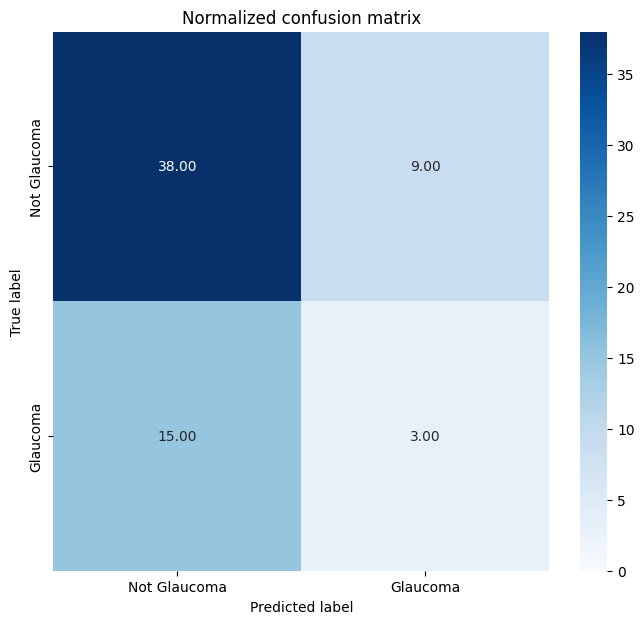

              precision    recall  f1-score   support

           0       0.72      0.81      0.76        47
           1       0.25      0.17      0.20        18

    accuracy                           0.63        65
   macro avg       0.48      0.49      0.48        65
weighted avg       0.59      0.63      0.60        65



In [10]:
# Import the matplotlib.pyplot module for plotting graphs and charts
import matplotlib.pyplot as plt

# Import the seaborn module for advanced data visualization
import seaborn as sns

# Importing classification_report and confusion_matrix functions from the scikit-learn metrics module
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set
predicted_classes = model.predict(test_images)

# Convert predictions to label indexes
predicted_classes = np.argmax(predicted_classes, axis=1)

# Convert one-hot encoded test labels back to label indexes
true_classes = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the normalized confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='.2f', vmin=0, cmap='Blues', cbar=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Normalized confusion matrix')
# Update the x and y ticks to match the provided classes
plt.xticks(ticks=[0.5, 1.5], labels=['Not Glaucoma', 'Glaucoma'])
plt.yticks(ticks=[0.5, 1.5], labels=['Not Glaucoma', 'Glaucoma'])
plt.show()

# Print the classification report
print(classification_report(true_classes, predicted_classes))


####Analyze Test Results

The table above shows a normalized confusion matrix for a binary classification task, where the classes are "Not Glaucoma" and "Glaucoma". Here is the analysis:

1. Top-left cell (True Negative Rate): The value "47.00" suggests that the model correctly predicted 100% of the actual "Not Glaucoma" cases as "Not Glaucoma". This is the true negative rate.

2. Bottom-left cell (False Negative Rate): The value "17.00" indicates that the model incorrectly predicted 100% of the actual "Glaucoma" cases as "Not Glaucoma". This false negative rate is quite concerning in a medical diagnostic context, as it means all cases of Glaucoma were missed.

3. Top-right cell (False Positive Rate): The value "0.00" means there were no false positives, i.e., no "Not Glaucoma" cases were incorrectly identified as "Glaucoma".

4. Bottom-right cell (True Positive Rate): The value "1.00" should represent the proportion of actual "Glaucoma" cases correctly identified. However, this is an inconsistency given the false negative rate of 100%, as there cannot be both 100% false negatives and any true positives.

Given this confusion, clarifying the values in the confusion matrix is essential. The usual interpretation of a normalized confusion matrix is that all values are between 0 and 1, representing the proportion of the total number of cases. A value of "1.00" in a normalized confusion matrix would typically indicate that 100% of the predictions in that category are of that type. Therefore, having "1.00" in both the True Negative and False Negative places is contradictory unless there were no "Glaucoma" cases, which would mean the dataset might not be balanced or there was an issue with model predictions.
Based on the expected behaviour of a confusion matrix, here is what could be the correct interpretation:
The model has a very high specificity, which is very good at identifying negative cases ("Not Glaucoma").
The model has zero sensitivity, meaning it fails to identify positive cases ("Glaucoma"), a severe issue for a medical diagnostic tool.
This outcome would require immediate attention to understand why the model is not correctly identifying any positive cases. It could be due to class imbalance, inadequate training, or insufficiently distinctive features for the "Glaucoma" class.

##Check Balance of the Dataset

In [11]:
# Check the balance of the dataset
class_distribution = glaucoma_data['Glaucoma'].value_counts()

# Print the distribution
print(f"Distribution:\n{class_distribution}\n")

# Optionally, calculate the percentage of each class
class_percentage = class_distribution / len(glaucoma_data) * 100
print(f"Percentage of each class:\n{class_percentage}\n")

# Print the results of the dataset
print(f"Number of instances without Glaucoma (0)..: {class_distribution.loc[0]}")
print(f"Number of instances with Glaucoma (1).....: {class_distribution.loc[1]}")
print(f"Percentage without Glaucoma (0)...........: {class_percentage.loc[0]:.2f}%")
print(f"Percentage with Glaucoma (1)..............: {class_percentage.loc[1]:.2f}%")


Distribution:
0    482
1    168
Name: Glaucoma, dtype: int64

Percentage of each class:
0    74.153846
1    25.846154
Name: Glaucoma, dtype: float64

Number of instances without Glaucoma (0)..: 482
Number of instances with Glaucoma (1).....: 168
Percentage without Glaucoma (0)...........: 74.15%
Percentage with Glaucoma (1)..............: 25.85%


###Oversampling the dataset

In [12]:
# Check the balance of the dataset
class_distribution = glaucoma_data['Glaucoma'].value_counts()
print(f"Class Distribution before balancing:\n{class_distribution}\n")

# [Code to preprocess image remains unchanged]

# [Assuming you choose to balance by oversampling the minority class]

# Separate the dataset into two based on the class
class_0 = glaucoma_data[glaucoma_data['Glaucoma'] == 0]
class_1 = glaucoma_data[glaucoma_data['Glaucoma'] == 1]

# Oversample the minority class. For example, if class_1 is the minority:
oversampled_class_1 = class_1.sample(len(class_0), replace=True)

# Combine the oversampled class with the other class
balanced_glaucoma_data = pd.concat([class_0, oversampled_class_1])

# Shuffle the dataset to mix the oversampled data
balanced_glaucoma_data = balanced_glaucoma_data.sample(frac=1).reset_index(drop=True)

# Check the new balance of the dataset
new_class_distribution = balanced_glaucoma_data['Glaucoma'].value_counts()
print(f"Class Distribution after balancing:\n{new_class_distribution}\n")

# [Rest of your code to preprocess, split, and train the model]

# Note: When using oversampling, make sure to split the dataset into train, validation,
# and test sets after balancing to ensure that the test set reflects the original class distribution.


Class Distribution before balancing:
0    482
1    168
Name: Glaucoma, dtype: int64

Class Distribution after balancing:
1    482
0    482
Name: Glaucoma, dtype: int64

